# **Industrial IoT Analytics Starter Kit**

This starter kit implements the system health monitoring use case using anomaly detection models. 

# Initialization



In [1]:
#
# Reinstall google-cloud-aiplatform
#

!pip3 uninstall -y google-cloud-aiplatform
!pip3 install google-cloud-aiplatform
 
import IPython
 
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.9 MB/s 
     |████████████████████████████████| 408 kB 55.2 MB/s 
     |████████████████████████████████| 47 kB 5.3 MB/s 
     |████████████████████████████████| 105 kB 48.0 MB/s 
     |████████████████████████████████| 115 kB 50.9 MB/s 
     |████████████████████████████████| 233 kB 49.1 MB/s 
     |████████████████████████████████| 106 kB 45.7 MB/s 
     |████████████████████████████████| 106 kB 46.7 MB/s 
     |████████████████████████████████| 107 kB 44.8 MB/s 
     |████████████████████████████████| 107 kB 50.1 MB/s 
     |████████████████████████████████| 107 kB 46.5 MB/s 
     |████████████████████████████████| 106 kB 13.3 MB/s 
     |████████████████████████████████| 106 kB 44.6 MB/s 
     |████████████████████████████████| 106 kB 35.1 MB/s 
     |████████████████████████████████| 106 kB 38.8 MB/s 
     |████████████████████████████

{'status': 'ok', 'restart': True}

In [1]:
#
# Authentication
#

import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [2]:
#
# Set some global variables with your project details and other information 
# WARNING: It is for internal use only, requires credentials for 
#    the project gd-gcp-rnd-price-optimization
#

from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y_%m_%d_%H%M%S")

REGION = "us-central1"
PROJECT_ID = "gd-gcp-rnd-price-optimization"
BUCKET_NAME = "gd-gcp-koliadin-iot1"
DATA_FOLDER = "vk2"  # a folder in the bucket or ""

TIMESTAMP  # show timestamp

'2022_11_10_103254'

In [ ]:
#
# Set global variables with your project details and other information
#

from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y_%m_%d_%H%M%S")

REGION = "us-central1"
PROJECT_ID = "my-project-name"
BUCKET_NAME = "my-bucket-name"
DATA_FOLDER = "vk2"  # a folder in the bucket or ""

TIMESTAMP  # show timestamp

In [3]:
#
# Mount Google-drive for outputs such as image files
#

from google.colab import drive
from datetime import datetime

drive.mount('/content/gdrive', force_remount=False)
folder = "prj/vertex_iot1-git/"
path = f"/content/gdrive/My Drive/{folder}"

!mkdir -p "$path"
!mkdir -p "$path/img"  # the directory for copies of output graphics
%cd $path

!echo "==> pwd= $(pwd)"
!echo -e "==> ls:\n$(ls)"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/prj/vertex_iot1-git
==> pwd= /content/gdrive/My Drive/prj/vertex_iot1-git
==> ls:
img


In [4]:
#
# Initialize AI the platform
#

from google.cloud import aiplatform
import os

aiplatform.init(project=PROJECT_ID, staging_bucket=BUCKET_NAME)
os.environ["GCLOUD_PROJECT"] = PROJECT_ID 

# Data Loading

Please put the following two files on Google Cloud Storage:
* [vk2_vk2-FORECAST-extra_8-noise_10000df-nf50_nd1500-seed_12345-train.csv](https://drive.google.com/file/d/1_oaE8gdxELBYqKqgoZdDs4CD_TcOaxIl/view?usp=sharing)
* [vk2_vk2-FORECAST-extra_8-noise_10000df-nf50_nd1500-seed_12345-test.csv](https://drive.google.com/file/d/1ycNk8vX-g_Oct_cLCOEe3KfcKm5IFHhT/view?usp=sharing)

#### Set GCS paths to the CSV-files and create the training dataset

In [5]:
import os
BASENAME = "vk2-FORECAST-extra_8-noise_10000df-nf50_nd1500-seed_12345"

CSV_TRAIN = os.path.join("gs://", BUCKET_NAME, DATA_FOLDER, f"{BASENAME}-train.csv")

TRAIN_DATASET = aiplatform.TabularDataset.create(
    display_name=f"{BASENAME}-auto", gcs_source=[CSV_TRAIN]
)
print(CSV_TRAIN)

Creating TabularDataset


INFO:google.cloud.aiplatform.datasets.dataset:Creating TabularDataset


Create TabularDataset backing LRO: projects/1099418293219/locations/us-central1/datasets/828787675761737728/operations/4699371314828279808


INFO:google.cloud.aiplatform.datasets.dataset:Create TabularDataset backing LRO: projects/1099418293219/locations/us-central1/datasets/828787675761737728/operations/4699371314828279808


TabularDataset created. Resource name: projects/1099418293219/locations/us-central1/datasets/828787675761737728


INFO:google.cloud.aiplatform.datasets.dataset:TabularDataset created. Resource name: projects/1099418293219/locations/us-central1/datasets/828787675761737728


To use this TabularDataset in another session:


INFO:google.cloud.aiplatform.datasets.dataset:To use this TabularDataset in another session:


ds = aiplatform.TabularDataset('projects/1099418293219/locations/us-central1/datasets/828787675761737728')


INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TabularDataset('projects/1099418293219/locations/us-central1/datasets/828787675761737728')


gs://gd-gcp-koliadin-iot1/vk2/vk2-FORECAST-extra_8-noise_10000df-nf50_nd1500-seed_12345-train.csv


#### Read the training dataset as a Pandas DataFrame from the bucket
  (Check the output for correct fields in the dataset and the number of rows)



In [6]:
import pandas as pd
from google.cloud import storage
from io import BytesIO

def read_csv_from_bucket(gcs_path, bucket_name, time_series_flag):
    # Get the blob:
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob_name = gcs_path.replace(f"gs://{bucket_name}/", "")
    # print(blob_name)
    blob = bucket.blob(blob_name)
    
    # Convert to DataFrame:
    contents = blob.download_as_string()
    csv_data = BytesIO(contents)

    if time_series_flag:
        df = pd.read_csv(csv_data, parse_dates=["datetime"])
    else:
        df = pd.read_csv(csv_data)

    n_feats = len(df['feature_id'].unique())
    n_dat = len(df) // n_feats
    assert len(df) % n_feats == 0
    #
    print(f" ==> {len(df)} rows are read from '{blob_name}'")
    print(f"  -> {n_feats} features")
    print(f"  -> {n_dat} data points")
    print("  -> Columns:")
    for i, col_i in enumerate(df.columns):
        print(f"    {i:02d}.  {col_i}")
    
    return df

DF_TRAIN = read_csv_from_bucket(CSV_TRAIN, BUCKET_NAME, time_series_flag=True)

 ==> 50000 rows are read from 'vk2/vk2-FORECAST-extra_8-noise_10000df-nf50_nd1500-seed_12345-train.csv'
  -> 50 features
  -> 1000 data points
  -> Columns:
    00.  datetime
    01.  feature_id
    02.  feature_value
    03.  x1
    04.  x2
    05.  x3
    06.  x4
    07.  x5
    08.  x6
    09.  x7
    10.  x8
    11.  x9
    12.  x10


# Model Training and Deployment

#### Train the model using Auto-ML Tabular Regression service

You may either specify a readily available Vertex AI model trained earlier (it takes no time) or to train a model from scratch (it takes about 1 hour for the default value `budget_milli_node_hours=1000`)

Be careful with ascribing columns attributes as well as with specifying data types (numerical or categorical).


In [8]:
# Set a model name (model ID) if available: use None for training from scratch
#MODEL_NAME = None  # Train the model from scratch (takes at least 1 hour)
#MODEL_NAME = '136880401565089792'  # Simply use this model (takes no time)
MODEL_NAME = '1419333172016971776'  # 2022-11-10 10:35:47 - git-project
model_display_name = f"{BASENAME}-model"  

# Specify the target column:
target_column="feature_value"

# Specify numeric and categorical columns
numeric_cols = ["feature_value"]
max_nof_covariates = 10  # the maximal number of covariates: "x1", "x2", ...
for i in range(max_nof_covariates):
    numeric_cols.append(f"x{i+1}")
categ_cols = ["feature_id"]  # the categorical column with feature ID

# Prepare column_transformations list
column_transformations=[]
for col_i in numeric_cols:
    column_transformations.append({"numeric": {"column_name": col_i}})
for col_i in categ_cols:
    column_transformations.append({"categorical": {"column_name": col_i}})

if MODEL_NAME is None or MODEL_NAME == "":     #  Train the model
    job = aiplatform.AutoMLTabularTrainingJob(
        display_name=f'vk-job-{model_display_name}-{TIMESTAMP}',
        optimization_prediction_type="regression",
        optimization_objective='minimize-rmse',
        column_transformations=column_transformations
    )
    # This will take around an hour to run
    model = job.run(
        dataset=TRAIN_DATASET,
        target_column=target_column,
        budget_milli_node_hours=1000,
        model_display_name=model_display_name, 
    )
    model.wait()
else:
    model = aiplatform.Model(MODEL_NAME)

# Display the model information
print("Model name: {}".format(model.name))
print("Model id: {}".format(model.name.split("/")[-1]))
print("Model display name: {}".format(model.display_name))
print("Model create time: {}".format(model.create_time))

Model name: 1419333172016971776
Model id: 1419333172016971776
Model display name: vk2-FORECAST-extra_8-noise_10000df-nf50_nd1500-seed_12345-model
Model create time: 2022-11-10 10:35:47.896164+00:00


####  Create an endpoint and deploy the model
* It may take 5-10 minutes
* Skip this cell if the model has already been trained and deployed

In [9]:
#
# Create an endpoint and deploy the model at this endpoint
#
endpoint_display_name = "vkgit-retrained_model"
endpoint = aiplatform.Endpoint.create(display_name=endpoint_display_name)
model.deploy(endpoint=endpoint, deployed_model_display_name=f"{endpoint_display_name}-deployed_model")

Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/1099418293219/locations/us-central1/endpoints/4871984401187078144/operations/1736565709971914752


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/1099418293219/locations/us-central1/endpoints/4871984401187078144/operations/1736565709971914752


Endpoint created. Resource name: projects/1099418293219/locations/us-central1/endpoints/4871984401187078144


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/1099418293219/locations/us-central1/endpoints/4871984401187078144


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/1099418293219/locations/us-central1/endpoints/4871984401187078144')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/1099418293219/locations/us-central1/endpoints/4871984401187078144')


Deploying model to Endpoint : projects/1099418293219/locations/us-central1/endpoints/4871984401187078144


INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/1099418293219/locations/us-central1/endpoints/4871984401187078144


Using default machine_type: n1-standard-2


INFO:google.cloud.aiplatform.models:Using default machine_type: n1-standard-2


Deploy Endpoint model backing LRO: projects/1099418293219/locations/us-central1/endpoints/4871984401187078144/operations/187327438156464128


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/1099418293219/locations/us-central1/endpoints/4871984401187078144/operations/187327438156464128


Endpoint model deployed. Resource name: projects/1099418293219/locations/us-central1/endpoints/4871984401187078144


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/1099418293219/locations/us-central1/endpoints/4871984401187078144


resource name: projects/1099418293219/locations/us-central1/endpoints/4871984401187078144

#### Set the endpoint with a model deployed

Skip this step if you have just created a new endpoint in a cell above

In [ ]:
# New endpoint
# resource name: projects/1099418293219/locations/us-central1/endpoints/6654565428695662592

In [ ]:
#
# Set a working endpoint by its ID
# 
endpoint_name = "1788448021554397184"
endpoint = aiplatform.Endpoint(endpoint_name=endpoint_name)

# Model Inference: Predicting the Expected State of the System


#### Read the data with IoT sensors readings
The format is the same as for the training data


In [10]:
CSV_TEST = os.path.join("gs://", BUCKET_NAME, DATA_FOLDER, f"{BASENAME}-test.csv")
DF_TEST = read_csv_from_bucket(CSV_TEST, BUCKET_NAME, time_series_flag=True)

 ==> 10000 rows are read from 'vk2/vk2-FORECAST-extra_8-noise_10000df-nf50_nd1500-seed_12345-test.csv'
  -> 50 features
  -> 200 data points
  -> Columns:
    00.  datetime
    01.  feature_id
    02.  feature_value
    03.  x1
    04.  x2
    05.  x3
    06.  x4
    07.  x5
    08.  x6
    09.  x7
    10.  x8
    11.  x9
    12.  x10


#### Define working functions for predictions and postprocessing

In [11]:
# NEW:
#  Make predictions and compute major statistics for the training dataset
#  (in this cell, only working functions are defined)

import numpy as np
MAX_BLOCK_SIZE = 100  # should be small enough to meet restrictions for endpoints

def df_to_json_instances(df):
    """ Fill the "instances" argument for endpoint.predict() 
        by values from all columns in "df"
        - each item corresponds to a row in "df"
        - each item is a dict column:value
    """
    
    instances = []
    for _, row_i in df.iterrows():
        instance_i = {}
        for col_j in list(df.columns):
            if col_j == "datetime":
                continue
            if col_j == "feature_id":
                instance_i[col_j] = f"{int(row_i[col_j])}"
            else:
                instance_i[col_j] = f"{float(row_i[col_j])}"
        instances.append(instance_i)
    return instances

def long_to_wide_df(values, n_feats):
    assert len(values) % n_feats == 0
    n_dat = len(values) // n_feats  # the number of datapoints
    values = values.reshape((n_dat, n_feats)).copy()
    df = pd.DataFrame(values, columns=range(n_feats), index=range(n_dat))
    return df

def predictions_field_to_df_wide(predictions, field_name, n_feats):
    """  Convert a field from "predictions" to an array
             where "predictions" are returned by endpoint.predict()
    """
    values = []
    for pred_i in predictions:
        values.append(pred_i[field_name])
    
    arr = np.array(values).astype(float)
    n_dat = len(arr) // n_feats  # the number of data points
    df_wide = long_to_wide_df(arr, n_feats)
    assert df_wide.shape[0] == n_dat
    assert df_wide.shape[1] == n_feats

    return df_wide

def mk_predictions(df_xy, endpoint, max_block_size=100):
    """  df_xy is in the long format:
           row: feature_id, x1, x2, ...,x10  feature_value
    """
    global N_FEATS

    df_x = df_xy.drop("feature_value", axis=1)
    print(df_x.columns)
    instances = df_to_json_instances(df_x)  # each instance is a dict feature:value

    #  We make requests for predictions to the endpoint by blocks because
    #      the size of the request is limited

    # Compute n_full_blocks, n_remain, etc
    n = len(instances)
    n_full_blocks = int(n / max_block_size)
    n_remain = int(n % max_block_size)
    n_feats = len(df_x["feature_id"].unique())
    assert n_feats == N_FEATS
    assert n % n_feats == 0
    n_dat = n // n_feats  # the number of data points
    
    # Split instances into arrays of instances
    arrays_of_instances = []
    for i in range(n_full_blocks):
        instances_i = instances[i * max_block_size: (i+1) * max_block_size]
        arrays_of_instances.append(instances_i)
    if n_remain != 0:
        instances_i = instances[-n_remain:]       
        arrays_of_instances.append(instances_i)

    #  Make predictions by blocks and combine in a single list:
    all_predictions = []
    for instances_i in arrays_of_instances:
        predictions_i = endpoint.predict(instances=instances_i)
        all_predictions.extend(predictions_i.predictions)

    # Return a list of dictionaries with keys: 
    #     "value", "lower_bound", "upper_bound"
    return all_predictions  

def df_xy_to_df_true(df_xy, n_feats):
    # Prepare true values in the wide format:
    true_vals = df_xy["feature_value"].values
    df_true = long_to_wide_df(true_vals, n_feats)
    return df_true

def standardize_obs_values(df_ref, df_obs):
    """  Compute the final statistic as the normalized deviation from the center
         - the center and the scale are computed from "_ref" data
         - the final stat is the  (x - center(x)) / scale(x)
         For a healthy system (behaving like in the training data), we expect
           that the distribution of such statistics is concentrated around 0 
           and has moderate scale (STD), say a few units.
         If a raw diagnostics metric takes anomalous values, the value of this statistics
           tends to take much larger positive values
    """
    center_ref = df_ref.mean(axis=0)
    scale_ref = df_ref.std(axis=0)
    df_stat = (df_obs - center_ref) / scale_ref
    return df_stat



#### Read the actually observed (test) data and make predictions via the endpoint

In [12]:
# Read the actually observed  (test) data
#    and make predictions via the endpoint

DF_TEST = read_csv_from_bucket(CSV_TEST, BUCKET_NAME, time_series_flag=False)

df_xy_ref = DF_TRAIN  # use the training dataset as the reference
df_xy_obs = DF_TEST   # these are the observed data in the long format
# 
N_FEATS = len(df_xy_ref["feature_id"].unique())
assert N_FEATS == len(df_xy_obs["feature_id"].unique())

# Prepare true values in the wide format:
df_ref_true = df_xy_to_df_true(df_xy_ref, N_FEATS)
df_obs_true = df_xy_to_df_true(df_xy_obs, N_FEATS)

# Make predictions from the endpoint (takes some time)
predictions_ref = mk_predictions(df_xy_ref, endpoint)
predictions_obs = mk_predictions(df_xy_obs, endpoint)




 ==> 10000 rows are read from 'vk2/vk2-FORECAST-extra_8-noise_10000df-nf50_nd1500-seed_12345-test.csv'
  -> 50 features
  -> 200 data points
  -> Columns:
    00.  datetime
    01.  feature_id
    02.  feature_value
    03.  x1
    04.  x2
    05.  x3
    06.  x4
    07.  x5
    08.  x6
    09.  x7
    10.  x8
    11.  x9
    12.  x10
Index(['datetime', 'feature_id', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7',
       'x8', 'x9', 'x10'],
      dtype='object')
Index(['datetime', 'feature_id', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7',
       'x8', 'x9', 'x10'],
      dtype='object')


#### Extract necessary data from the predictions obtained from the endpoint

In [13]:
# Prepare predicted values in the wide format:
df_ref_pred = predictions_field_to_df_wide(predictions_ref, "value", N_FEATS)
df_obs_pred = predictions_field_to_df_wide(predictions_obs, "value", N_FEATS)

# Prepare the lower and upper bounds (95%-confidence interval) for new data:
df_lower_obs = predictions_field_to_df_wide(predictions_obs, "lower_bound", N_FEATS)
df_upper_obs = predictions_field_to_df_wide(predictions_obs, "upper_bound", N_FEATS)

#### Visualize confidence intervals for all observations


In [18]:
!mkdir -p "./img"  # create a directory for copies of output images

(200, 50)
(200, 50)


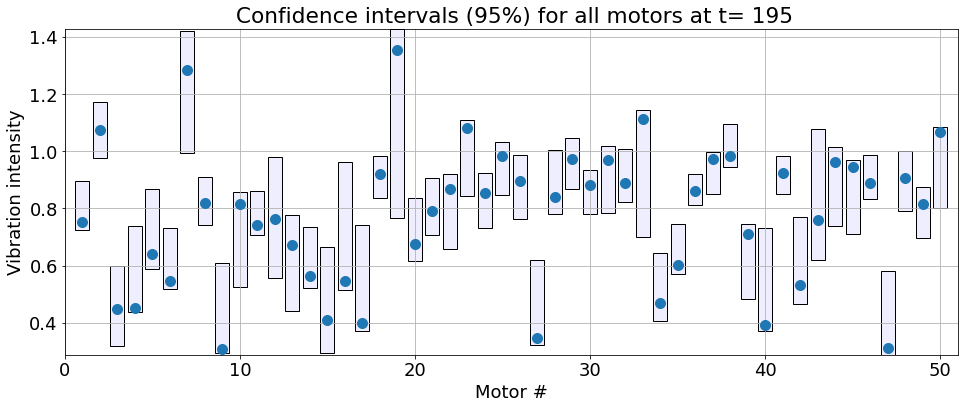

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams.update({'font.size': 18})
img_path = f"img/fig_confidence_intervals.png"

def plot_conf_intervals(ax, y, y_lower, y_upper):
    n = len(y_true)
    x = np.array(range(n)) + 1  
    ax.set_xlabel("Motor #")
    ax.set_ylabel(f"Vibration intensity")
    ax.plot(x, y, 'o', ms=10)

    ax.set_xlim(0., n+1)
    y_min = min(y_lower.min(), y.min(), y_upper.min())
    y_max = max(y_lower.max(), y.max(), y_upper.max()) 
    ax.set_ylim(y_min, y_max)

    x_size_i = 0.8  
    for i in range(n):
        xy0_i = (i+1-x_size_i/2, y_lower.iloc[i])

        y_size_i = abs(y_upper.iloc[i] - y_lower.iloc[i])
        ax.add_patch(Rectangle(xy0_i, x_size_i, y_size_i,
            edgecolor = 'black',
            facecolor = '#EEEEFF',
            fill=True,
            lw=1)
    )
    
    ax.grid()
    return

print(df_obs_true.shape)
print(df_obs_pred.shape)
ti = 195  # the number of the datapoint
y_true = df_obs_true.iloc[ti,:]
y_pred = df_obs_pred.iloc[ti,:]
y_lower = df_lower_obs.iloc[ti,:]
y_upper = df_upper_obs.iloc[ti,:]

fig_size_inches = (16, 6)
title = f" Confidence intervals (95%) for all motors at t= {ti}"

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(fig_size_inches)
ax.set_title(title)

plot_conf_intervals(ax, y_true, y_lower, y_upper)

if img_path is not None:
    plt.savefig(img_path, bbox_inches='tight')

plt.show()
plt.close()

plt.close()

# Anomaly Scoring

The anomaly scores are computed as the ratio of the observed vibration intensity (a raw diagnostics metric) to its value predicted by ML-model, which has been trained on healthy data.

#### Compute the anomaly scores and standardize their values

We standatdize values of a statistic using its location (the mean) and the scale (the STD) computed for heatlhy system

In [16]:
#  Compute anomaly scores as true/pred ratios for each raw diagnostics metric:
df_ref_ratio = df_ref_true / df_ref_pred
df_obs_ratio = df_obs_true / df_obs_pred

# Compute the final statistics (standartized) for the healthy _true and _ratio
df_stat_true_h0 = standardize_obs_values(df_ref_true, df_ref_true)     # raw diagnostic metrics
df_stat_ratio_h0 = standardize_obs_values(df_ref_ratio, df_ref_ratio)  # anomaly scores

# Compute the final statistics (standartized) for the observed _true and _ratio
df_stat_true = standardize_obs_values(df_ref_true, df_obs_true)     # raw diagnonstic metrics
df_stat_ratio = standardize_obs_values(df_ref_ratio, df_obs_ratio)  # anomaly scores

#### Visualize the raw diagnostics metrics and anomaly scores

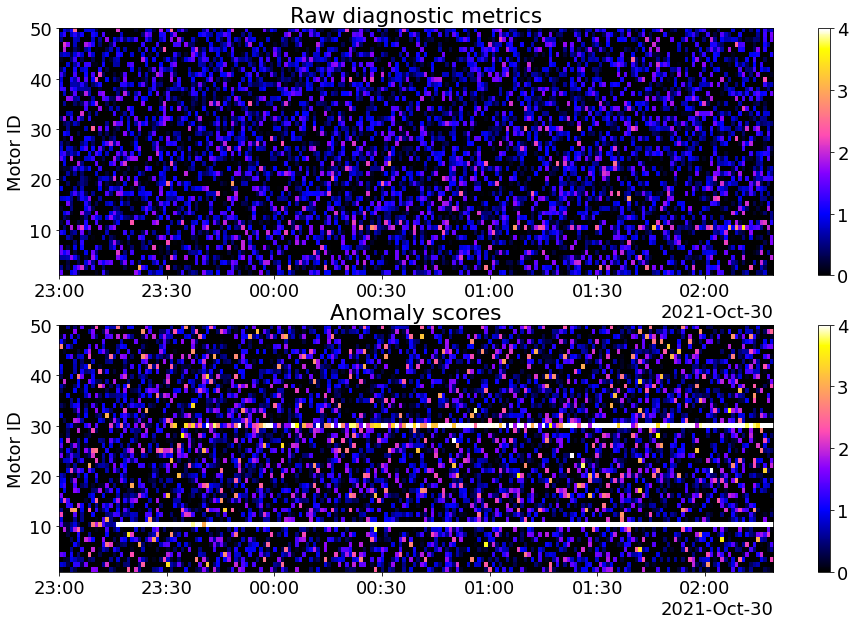

In [17]:
import matplotlib.pyplot as plt
from pylab import cm
from matplotlib.colors import Normalize
from copy import deepcopy
import matplotlib.dates as mdates

TEST_START = "2021-10-29 23:00:00"

def plot_vector_timeseries(ax, df_ts, vmin=None, vmax=None, qmax=0.99, x_is_date=True):
    df = df_ts.copy()
    n = len(df.columns)
    nt = len(df.index)
       
    if vmin is None:
        vmin = 1.0
    if vmax is None:
        print(f" ==> qmax= {qmax}")  # vk_remove
        vmax = np.quantile(df.values.reshape(-1), q=qmax)
    
    x_lims = [df.index.min(), df.index.max()]
    y_lims = [1, n]
    
    if x_is_date:  # the X-axis reflects datetime
        x_lims = mdates.date2num(x_lims)
    extent = (x_lims[0], x_lims[1], y_lims[0], y_lims[1])
    
    ax.set_ylabel("Motor ID")

    nmz = Normalize(vmin, vmax)
    cmap = cm.gnuplot2
    im = ax.imshow(np.transpose(df.values), extent=extent, norm=nmz, cmap=cmap, origin="lower", aspect="auto", interpolation="none")
    plt.colorbar(im, ax=ax)    
    
    if x_is_date:
        locator = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
    
    return

def plot2feature_sets(
        df1, df2, qmax=0.99, vmin=None, vmax1=None, vmax2=None, img_path=None,
        fig_size_inches=(16, 10)
):
    assert len(df1) == len(df2)
    df1 = df1.copy()
    df2 = df2.copy()
    
    x_range = pd.date_range(TEST_START, freq="60S", periods=len(df1))
    df1.index = x_range
    df2.index = x_range

    fig, ax2 = plt.subplots(2, 1)
    fig.set_size_inches(fig_size_inches)

    ax2[0].set_title(f"Raw diagnostic metrics")
    ax2[1].set_title("Anomaly scores")
    plot_vector_timeseries(ax2[0], df1, vmin=vmin, vmax=vmax1, qmax=qmax)
    plot_vector_timeseries(ax2[1], df2, vmin=vmin, vmax=vmax2, qmax=qmax)

    if img_path is not None:
        plt.savefig(img_path, bbox_inches='tight')
    
    plt.show()
    plt.close()
    return

def plot_feature_set(
        df, qmax=0.99, vmin=None, vmax=None, img_path=None, title="Title",
        fig_size_inches=(16, 6)
):
    df = df.copy()
    x_range = pd.date_range(TEST_START, freq="60S", periods=len(df))
    df.index = x_range

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(fig_size_inches)

    ax.set_title(title)
    plot_vector_timeseries(ax, df, vmin=vmin, vmax=vmax, qmax=qmax)

    if img_path is not None:
        plt.savefig(img_path, bbox_inches='tight')
    
    plt.show()
    plt.close()
    return

img_path = "img/fig-traditional_vs_our.png"
plot2feature_sets(df_stat_true, df_stat_ratio, vmin=0., img_path=img_path, vmax1=4, vmax2=4)

#img_path = "img/healthy_system.png"
#plot_feature_set(df=df_stat_true, vmin=0.0, vmax=4.0, img_path=img_path, title="Healthy system")

# Anomaly Detection


####     Compute the detection thresholds


In [18]:
ALPHA = 0.01  # The maximal allowed false positive rate

# Compute the final statistics (standartized) for the healthy _true and _ratio
df_stat_true_h0 = standardize_obs_values(df_ref_true, df_ref_true)     # raw diagnostic metrics
df_stat_ratio_h0 = standardize_obs_values(df_ref_ratio, df_ref_ratio)  # anomaly scores

# Aggregate healthy data by averaging over all motors:
stat_true_h0 = df_stat_true_h0.mean(axis=1)
stat_ratio_h0 = df_stat_ratio_h0.mean(axis=1)

# Compute the detection thresholds as quantiles (1.0 - ALPHA)
threshold_true = stat_true_h0.quantile(q=1.0 - ALPHA)
threshold_ratio = stat_ratio_h0.quantile(q=1.0 - ALPHA)

#### Visualize the detection process

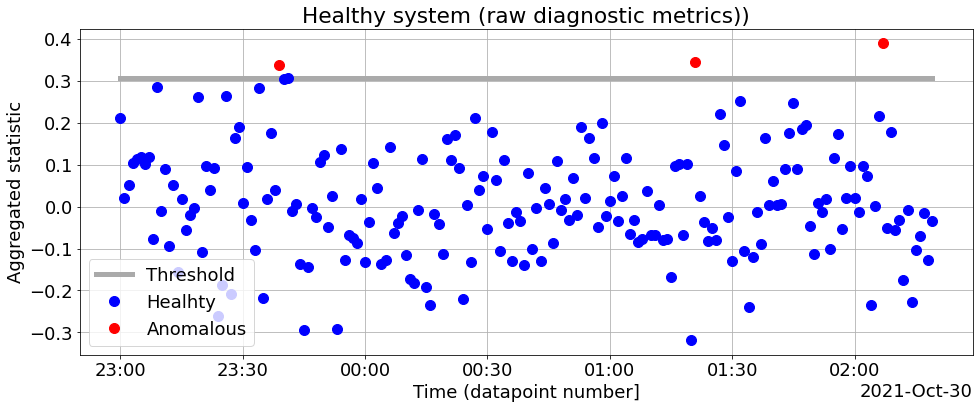

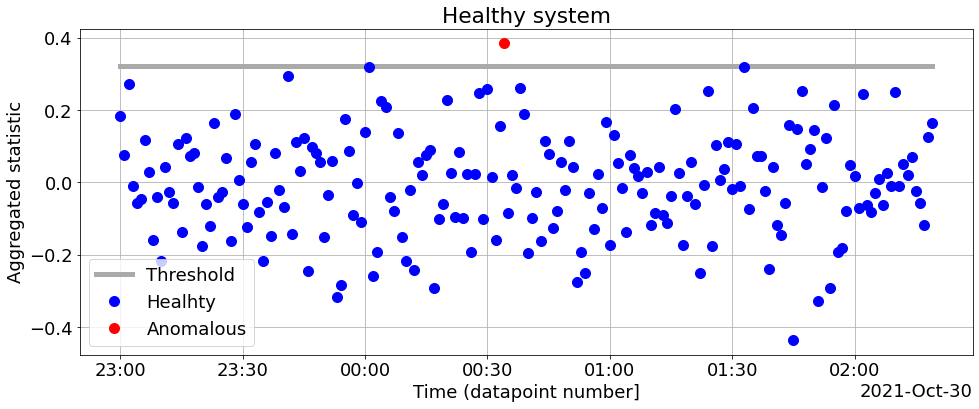

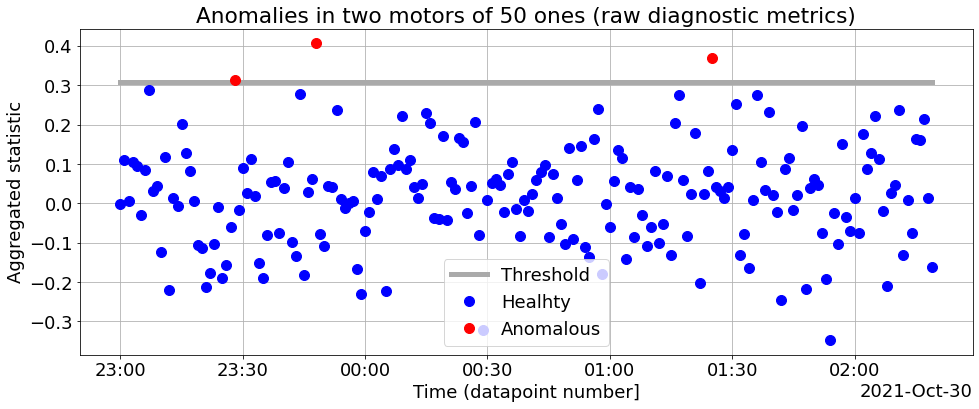

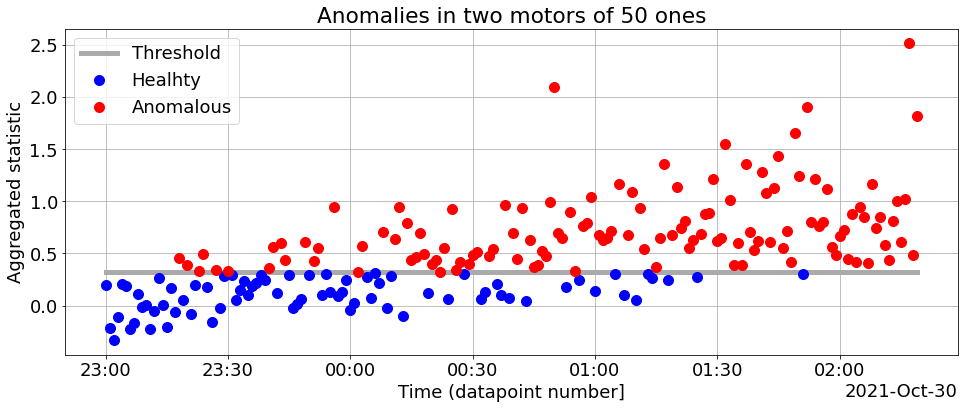

In [19]:
import matplotlib.pyplot as plt

TEST_START = "2021-10-29 23:00:00"  # vk_remove
plt.rcParams.update({'font.size': 18})

def visualize_detection(stat_values, threshold, img_path=None, title=None):
    figsize_inches = (16, 8)

    healthy_color = "blue" # if anomaly is not detected
    anom_color = "red"  # if anomaly is detected
    threshold_color = "#AAAAAA"

    nt = len(stat_values)  # the length of the series
    #x = np.array(range(nt)) + 1.0
    x = pd.date_range(TEST_START, freq="60S", periods=len(stat_values))
    y_threshold = np.full(nt, threshold)

    # Split x,y values into healthy and anomalous:
    idx_healthy = stat_values < threshold
    idx_anom = stat_values >= threshold
    x_healthy = x[idx_healthy]
    x_anom = x[idx_anom]
    y_healthy = stat_values[idx_healthy]
    y_anom = stat_values[idx_anom]

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(fig_size_inches)

    if title is not None:
        ax.set_title(title)

    ax.set_xlabel("Time (datapoint number]")
    ax.set_ylabel(f"Aggregated statistic")
    ax.plot(x, y_threshold, '-', lw=5, color=threshold_color, label="Threshold")
    ax.plot(x_healthy, y_healthy, 'o', ms=10, color=healthy_color, label="Healhty")
    ax.plot(x_anom, y_anom, 'o', ms=10, color=anom_color, label="Anomalous")

    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)        
    
    ax.grid()
    ax.legend()
    
    if img_path is not None:
        plt.savefig(img_path, bbox_inches='tight')
    
    plt.show()
    plt.close()

    return

# Aggregate the reference (healthy) data by averaging over all motors
#     and choose an interval of the same duration as the observed data:
nt = len(df_stat_true)
stat_true_h0 = df_stat_true_h0.mean(axis=1).iloc[-nt:]
stat_ratio_h0 = df_stat_ratio_h0.mean(axis=1).iloc[-nt:]


# Aggregate the observed data by averaging over all motors:
stat_true = df_stat_true.mean(axis=1)
stat_ratio = df_stat_ratio.mean(axis=1)

# Visualize the reference data from the healthy system:
visualize_detection(
    stat_true_h0,
    threshold_true, 
    img_path="img/fig-detect-true_h0.png",
    title="Healthy system (raw diagnostic metrics))"
)
visualize_detection(
    stat_ratio_h0,
    threshold_ratio, 
    img_path="img/fig-detect-ratio_h0.png",
    title="Healthy system"
)

# Visualize the observed (test) data with anomalies in two motors:
visualize_detection(
    stat_true, 
    threshold_true, 
    img_path="img/fig-detect-true_h1.png",
    title="Anomalies in two motors of 50 ones (raw diagnostic metrics)"
)  
visualize_detection(
    stat_ratio, 
    threshold_ratio, 
    img_path="img/fig-detect-ratio_h1.png",
    title="Anomalies in two motors of 50 ones"
)    



# Cleanup
Undeploy the model and delete the endpoint

In [ ]:
endpoint.list_models()  # See the ID of the deployed model (differs from the ID of the model itself)

In [ ]:
# If you are going to remove the endpoint, you should undeploy the model(s) first:
endpoint.undeploy(deployed_model_id="999029459136806912") # look for the ID in endpoint.list_models() output

Undeploying Endpoint model: projects/1099418293219/locations/us-central1/endpoints/1788448021554397184


INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/1099418293219/locations/us-central1/endpoints/1788448021554397184


NotFound: ignored

In [ ]:
endpoint.delete()